# sbc.nc
## sustress, svstress

In [20]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

proj_dir = os.environ['proj_dir']
processed_path = os.path.join(proj_dir,'data','preprocessing','processed')

sbc = xr.open_dataset(os.path.join(processed_path,'waom10_sbc.nc'))
grid_ds = xr.open_dataset(os.path.join(processed_path,'waom10_grd.nc'))

In [36]:
# %load ../../../toolBox/myTools/uv_vectorplot_avg.py
from numpy import *
sys.path.append(os.path.join(proj_dir,'src'))
from features.rotate_vector_roms import *
import cmocean

def uv_vectorplot (u_da,v_da,grd_ds,grd_type='rho'):

    # Radius of the Earth in metres
    r = 6.371e6
    # Degrees to radians conversion factor
    deg2rad = pi/180
    # Side length of blocks to average vectors over (can't plot vector at every
    # single point or the plot will be way too crowded)
    block = 15

    lon = grd_ds.lon_rho.values
    lat = grd_ds.lat_rho.values
    
    u = u_da.values
    v = v_da.values
    
    if grd_type != 'rho':
        
        angle = zeros(shape(lon))
        u_rho,v_rho = rotate_vector_roms(u, v, angle)
        
    else:
        
        u_rho = u
        v_rho = v

    speed = sqrt(square(u_rho)+square(v_rho))

    print('initialize and fill up the arrays')
    numy = size(lon,0) #530
    numx = size(lon,1) #630
    x = arange(numx)
    y = arange(numy)
    xmesh,ymesh = meshgrid(x,y)
    #print(numx,numy,x,y)

    # Average x, y, u_circ, and v_circ over block x block intervals
    # Calculate number of blocks
    size0 = int(ceil(numy/float(block)))
    size1 = int(ceil(numx/float(block)))
    # Set up arrays for averaged fields
    x_block = ma.empty([size0, size1])
    y_block = ma.empty([size0, size1])
    u_block = ma.empty([size0, size1])
    v_block = ma.empty([size0, size1])
    # Set up arrays containing boundary indices
    posn0 = list(arange(0, numy, block))
    posn0.append(numy)
    posn1 = list(arange(0, numx, block))
    posn1.append(numx)
    #print(posn0,posn1)
    # Double loop to average each block (can't find a more efficient way to do
    # this)
    for j in arange(size0):
        for i in arange(size1):
            start0 = posn0[j]
            end0 = posn0[j+1]
            start1 = posn1[i]
            end1 = posn1[i+1]
            x_block[j,i] = mean(xmesh[start0:end0, start1:end1])
            y_block[j,i] = mean(ymesh[start0:end0, start1:end1])
            u_block[j,i] = mean(u_rho[start0:end0, start1:end1])
            v_block[j,i] = mean(v_rho[start0:end0, start1:end1])
            
    return [speed,u_block,v_block,x_block,y_block]

In [18]:
u_mean = sbc.sustr.mean(axis=0)
v_mean = sbc.svstr.mean(axis=0)

In [37]:
speed,u_block,v_block,x_block,y_block = uv_vectorplot(u_mean,v_mean,grid_ds,"uv")

initialize and fill up the arrays


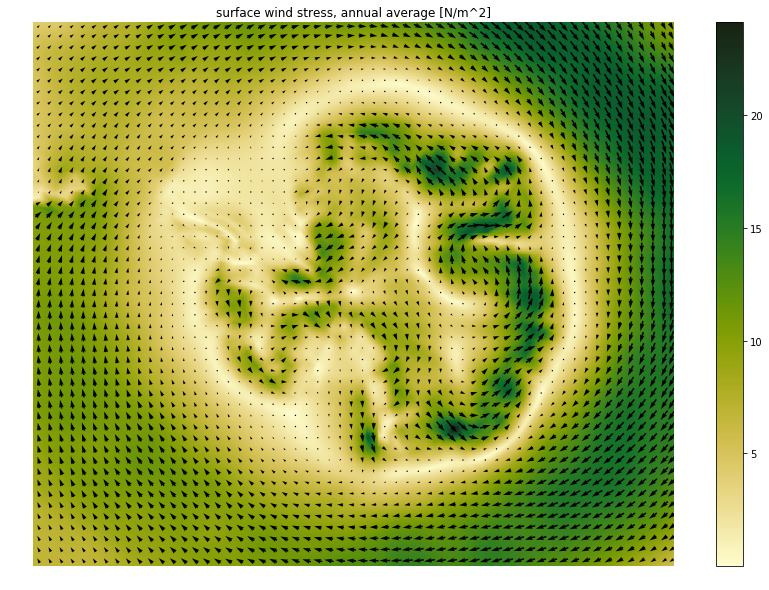

In [38]:
plt.close()        
# Make the plot
fig,ax0 = plt.subplots(1,figsize=(15,10))

speedP = plt.pcolormesh(speed*100, cmap=cmocean.cm.speed)
plt.colorbar(speedP,ax=ax0)
# Add vectors for each block
quiverP = ax0.quiver(x_block, y_block, u_block, v_block,pivot="mid", color='black',units="width")
plt.quiverkey(quiverP, 0.7, 0.99, 0.2, r'$20 \frac{cm}{s}$', labelpos='E',
                   coordinates='figure')

ax0.set_aspect('equal')
ax0.axis('off')
title("surface wind stress, annual average [N/m^2]")
plt.show()


... looks ok.